In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import MaxNLocator
import scienceplots
from matplotlib.lines import Line2D

# Cargado de Datos

In [26]:
exps = ['exp1', 'exp2', 'exp3']
dfs = {}  # diccionario donde guardamos los DataFrames por experimento

for exp in exps:
    lista_dfs = []
    for generacion in range(38):
        ruta_archivo = f'resultados/{exp}/resultados_generacion_{generacion}.csv'
        if os.path.exists(ruta_archivo):
            datos = pd.read_csv(ruta_archivo)
            datos['generacion'] = generacion
            lista_dfs.append(datos)
        else:
            print(f'Archivo no encontrado: {ruta_archivo}')
            break
    
    # unir todos los de este experimento en un DataFrame
    dfs[exp] = pd.concat(lista_dfs, ignore_index=True)

# ahora accedés así:
df_exp1 = dfs['exp1']
df_exp2 = dfs['exp2']
df_exp3 = dfs['exp3']

Archivo no encontrado: resultados/exp1/resultados_generacion_36.csv
Archivo no encontrado: resultados/exp2/resultados_generacion_22.csv


In [27]:
df_exp1

,D,A,B,x,y,fitness,generacion
0,83.626976,0.000496,21.974182,416.0,496.0,0.845207,0
1,6.494542,0.000324,1.872564,515.0,503.0,1.323900,0
2,96.433609,0.000217,17.221539,385.0,574.0,0.537906,0
3,11.028158,0.000200,11.862853,454.0,554.0,0.749674,0
4,49.082073,0.000149,15.561389,491.0,560.0,0.876539,0
...,...,...,...,...,...,...,...
359995,19.158033,0.000131,15.031912,384.0,556.0,0.414724,35
359996,18.195908,0.000075,16.744595,394.0,589.0,0.098284,35
359997,30.862289,0.000106,13.014239,405.0,596.0,0.177079,35
359998,22.835627,0.000182,10.997372,449.0,590.0,0.592922,35


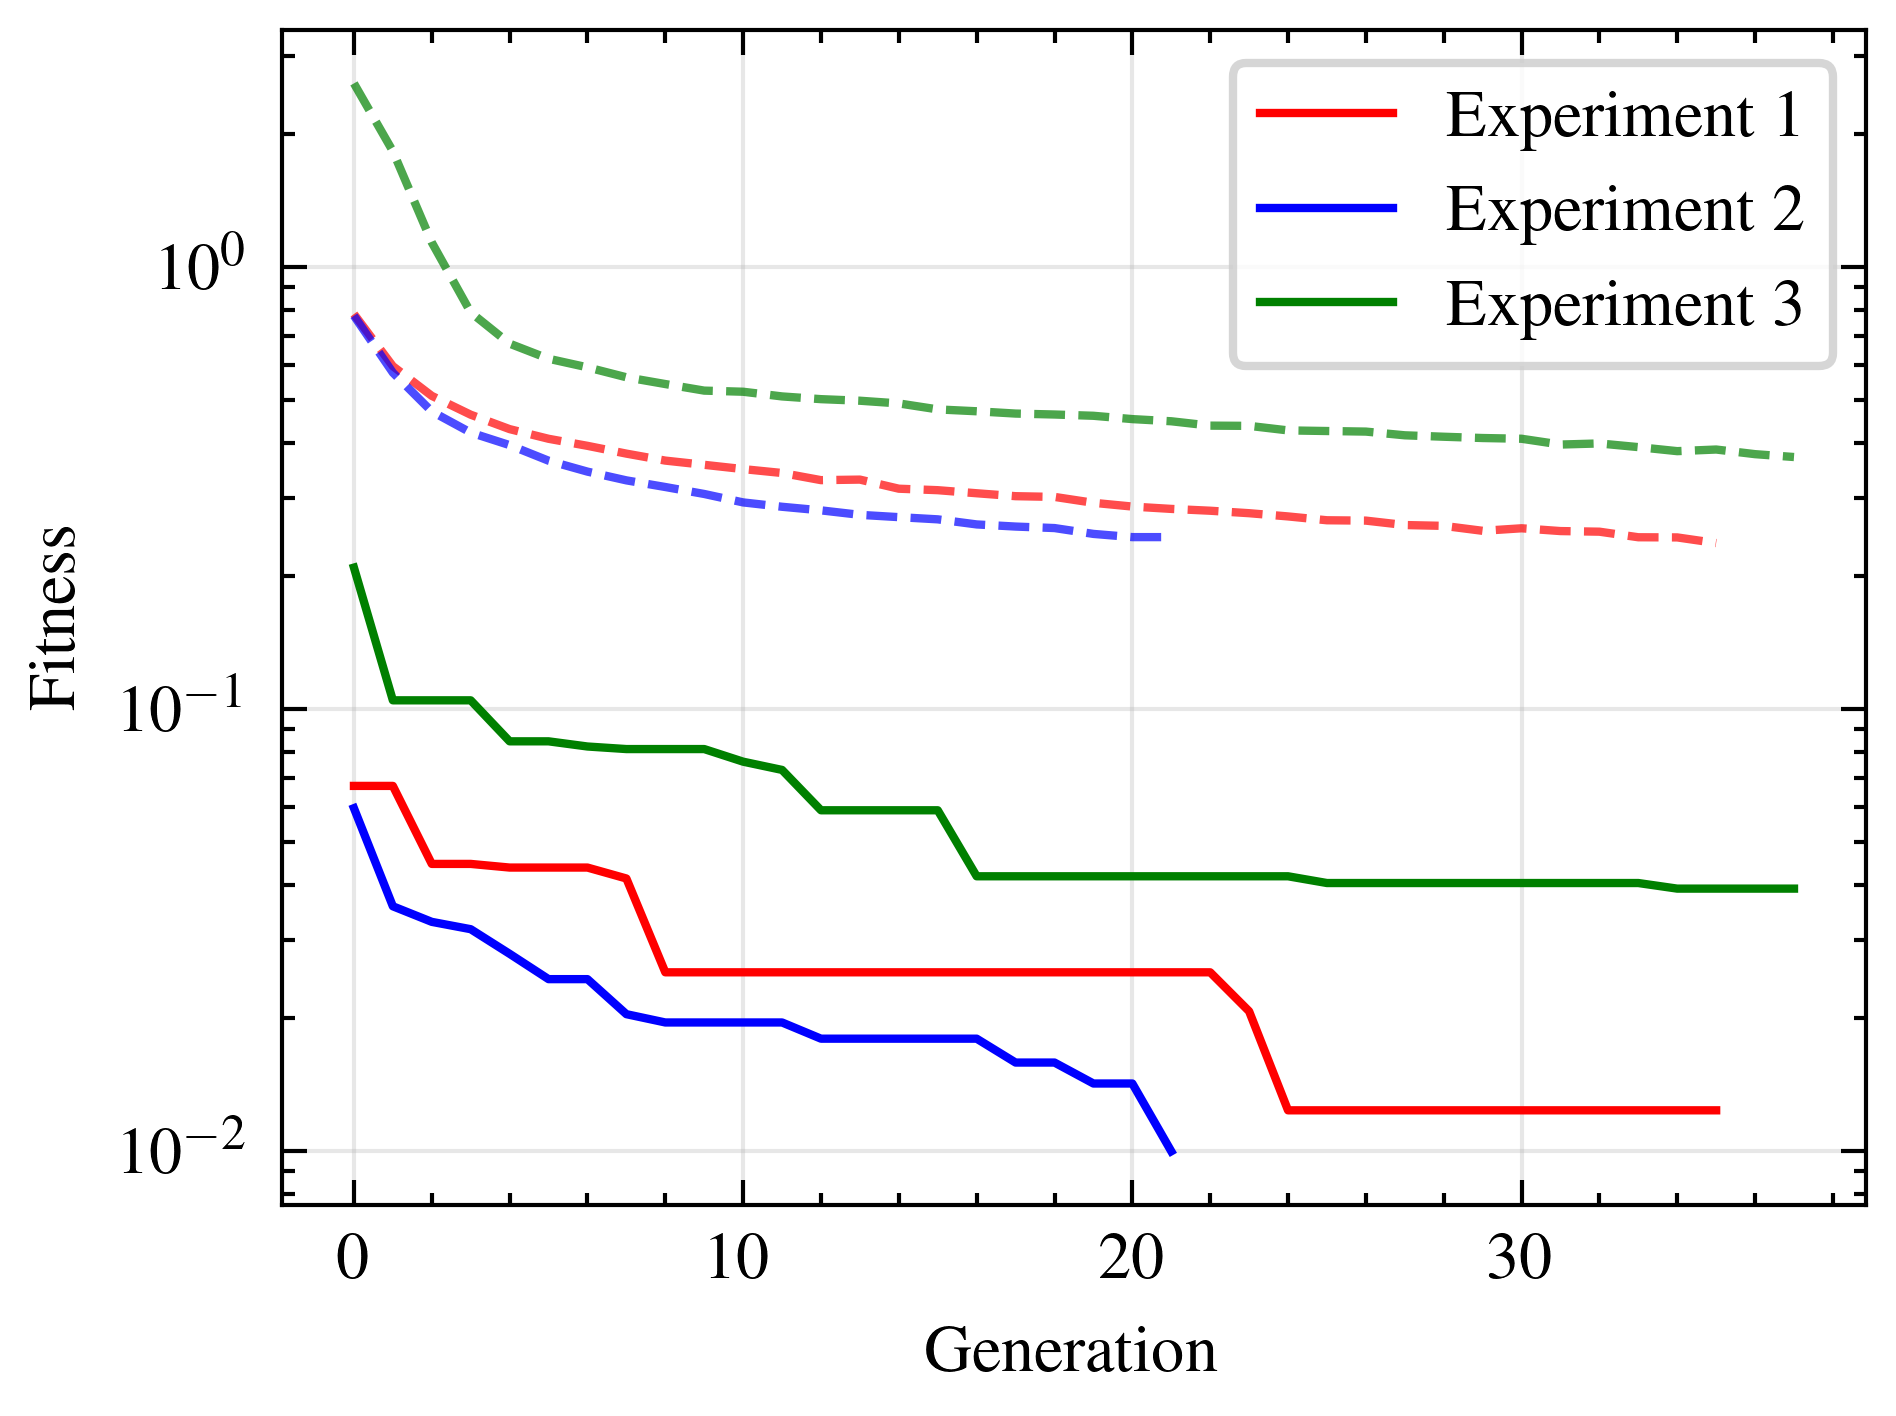

In [28]:
# Visualizaciones de los resultados del algoritmo genético

# Evolución del fitness a lo largo de las generaciones

# Experimento 1
mejor_fitness_exp1 = df_exp1.groupby('generacion')['fitness'].min()
fitness_promedio_exp1 = df_exp1.groupby('generacion')['fitness'].mean()

# Experimento 2
mejor_fitness_exp2 = df_exp2.groupby('generacion')['fitness'].min()
fitness_promedio_exp2 = df_exp2.groupby('generacion')['fitness'].mean()

# Experimento 3
mejor_fitness_exp3 = df_exp3.groupby('generacion')['fitness'].min()
fitness_promedio_exp3 = df_exp3.groupby('generacion')['fitness'].mean()

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    plt.yscale('log')
    
    # Exp1
    ax.plot(mejor_fitness_exp1.index, mejor_fitness_exp1.values, '-', color='red')
    ax.plot(fitness_promedio_exp1.index, fitness_promedio_exp1.values, '--', color='red', alpha=0.7)

    # Exp2
    ax.plot(mejor_fitness_exp2.index, mejor_fitness_exp2.values, '-', color='blue')
    ax.plot(fitness_promedio_exp2.index, fitness_promedio_exp2.values, '--', color='blue', alpha=0.7)

    # Exp3
    ax.plot(mejor_fitness_exp3.index, mejor_fitness_exp3.values, '-', color='green')
    ax.plot(fitness_promedio_exp3.index, fitness_promedio_exp3.values, '--', color='green', alpha=0.7)

    # handles personalizados para la leyenda
    legend_elements = [
        Line2D([0], [0], color='red', lw=1, label='Experiment 1'),
        Line2D([0], [0], color='blue', lw=1, label='Experiment 2'),
        Line2D([0], [0], color='green', lw=1, label='Experiment 3'),
    ]
    ax.legend(handles=legend_elements, frameon=True, loc='best')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('fitness_evolution.pdf', dpi=600, bbox_inches='tight')
    plt.show()

## Experimento 1

En este experimento ajustamos los parámetros: $D$, $A$, $B$ y las coordenadas del punto de ignición $(x,y)$.

In [29]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp1.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "x", "y"
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   Punto de ignición: ({row['x']}, {row['y']})")
    print(f"   Fitness = {row['fitness']}")


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#291862
   Generación: 29.0
   D = 10.324657440185549
   A = 9.344815771328284e-05
   B = 15.851767539978027
   Punto de ignición: (400.0, 599.0)
   Fitness = 0.012355464378963

#243169
   Generación: 24.0
   D = 11.099599838256836
   A = 0.0001035727909766
   B = 15.026252746582031
   Punto de ignición: (400.0, 603.0)
   Fitness = 0.0207012308839985

#325348
   Generación: 32.0
   D = 13.503010749816896
   A = 0.0001093767932616
   B = 14.915903091430664
   Punto de ignición: (402.0, 604.0)
   Fitness = 0.0223797090637821

#351717
   Generación: 35.0
   D = 14.43332576751709
   A = 6.265026604523882e-05
   B = 15.851767539978027
   Punto de ignición: (406.0, 597.0)
   Fitness = 0.0245710555762775

#192053
   Generación: 19.0
   D = 11.099599838256836
   A = 0.0001035727909766
   B = 15.026252746582031
   Punto de ignición: (400.0, 600.0)
   Fitness = 0.0253636702722864

#161934
   Generación: 16.0
   D = 10.5048189163208
   A = 0.0001445544185116
   

In [22]:
ultima_gen = df_exp1["generacion"].max()

df_ultima = df_exp1[df_exp1["generacion"] == ultima_gen].drop(columns=["generacion"])

df_ultima_sorted = df_ultima.sort_values("fitness", ascending=True)
df_ultima_topk = df_ultima_sorted.head(100)

df_ultima_topk


,D,A,B,x,y,fitness
321528,10.324657,0.000093,15.851768,400.0,599.0,0.012355
325347,13.503011,0.000109,14.915903,402.0,604.0,0.022380
324730,16.235876,0.000080,14.996048,408.0,599.0,0.031705
322582,15.569956,0.000077,13.956324,407.0,599.0,0.031751
321969,14.829347,0.000046,17.381268,406.0,594.0,0.040703
...,...,...,...,...,...,...
329593,23.550102,0.000028,15.314719,415.0,594.0,0.060425
320892,21.502810,0.000076,12.334015,408.0,590.0,0.060472
321524,15.361934,0.000109,14.031832,409.0,601.0,0.060658
326421,18.198202,0.000054,14.004227,415.0,597.0,0.060752


### Bootstrapping para darle un intervalo de confianza al mejor individuo

In [ ]:
import cupy as cp

def bootstrap_confidence_intervals_df(df, param_cols, fitness_col='fitness', n_bootstrap=100, alpha=0.05):
    """
    Calcula intervalos de confianza para:
    - la media de los parámetros
    - los parámetros del mejor individuo (fitness mínimo)

    Args: 
        df: pandas.DataFrame con columnas de parámetros y fitness
        param_cols: lista con nombres de columnas de parámetros
        fitness_col: nombre d ela columna de fitness
        n_bootstrap: número de remuestreos
        alpha: nivel de significancia (0.05 -> IC 95%)
    
    Returns:
        dict con dos DataFrames:
            - mean_params_CI
            - best_params_CI
    """

    # Convertimos a cupy
    poblacion_params = cp.asarray(df[param_cols].values)
    poblacion_fitness = cp.asarray(df[fitness_col].values)

    N, d = poblacion_params.shape
    mean_params_samples = cp.zeros((n_bootstrap, d))
    best_params_samples = cp.zeros((n_bootstrap, d))

    rng = cp.random.default_rng()

    for i in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        sample_params = poblacion_params[idx]
        sample_fitness = poblacion_fitness[idx]

        # media de parámetros
        mean_params_samples[i] = sample_params.mean(axis=0)

        # mejores parámetros
        best_idx = cp.argmin(sample_fitness)
        best_params_samples[i] = sample_params[best_idx]

    low_q = 100 * (alpha/2)
    high_q = 100 * (1 - alpha/2)

    mean_params_CI = cp.percentile(mean_params_samples, [low_q, high_q], axis=0)
    best_params_CI = cp.percentile(best_params_samples, [low_q, high_q], axis=0)

    mean_df = pd.DataFrame({
        "param": param_cols,
        "low": mean_params_CI[0].get(),
        "high": mean_params_CI[1].get()
    })

    best_df = pd.DataFrame({
        "param": param_cols,
        "low": best_params_CI[0].get(),
        "high": best_params_CI[1].get()
    })

    return {"mean_params_CI": mean_df, "best_params_CI": best_df}


# res = bootstrap_confidence_intervals_df(df_ultima_topk, param_cols=["D", "A", "B", "x", "y"])

# print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
# print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

,D,A,B,x,y,fitness
321528,10.324657,0.000093,15.851768,400.0,599.0,0.012355
325347,13.503011,0.000109,14.915903,402.0,604.0,0.022380
324730,16.235876,0.000080,14.996048,408.0,599.0,0.031705
322582,15.569956,0.000077,13.956324,407.0,599.0,0.031751
321969,14.829347,0.000046,17.381268,406.0,594.0,0.040703
...,...,...,...,...,...,...
329593,23.550102,0.000028,15.314719,415.0,594.0,0.060425
320892,21.502810,0.000076,12.334015,408.0,590.0,0.060472
321524,15.361934,0.000109,14.031832,409.0,601.0,0.060658
326421,18.198202,0.000054,14.004227,415.0,597.0,0.060752


### Análisis de la última generación

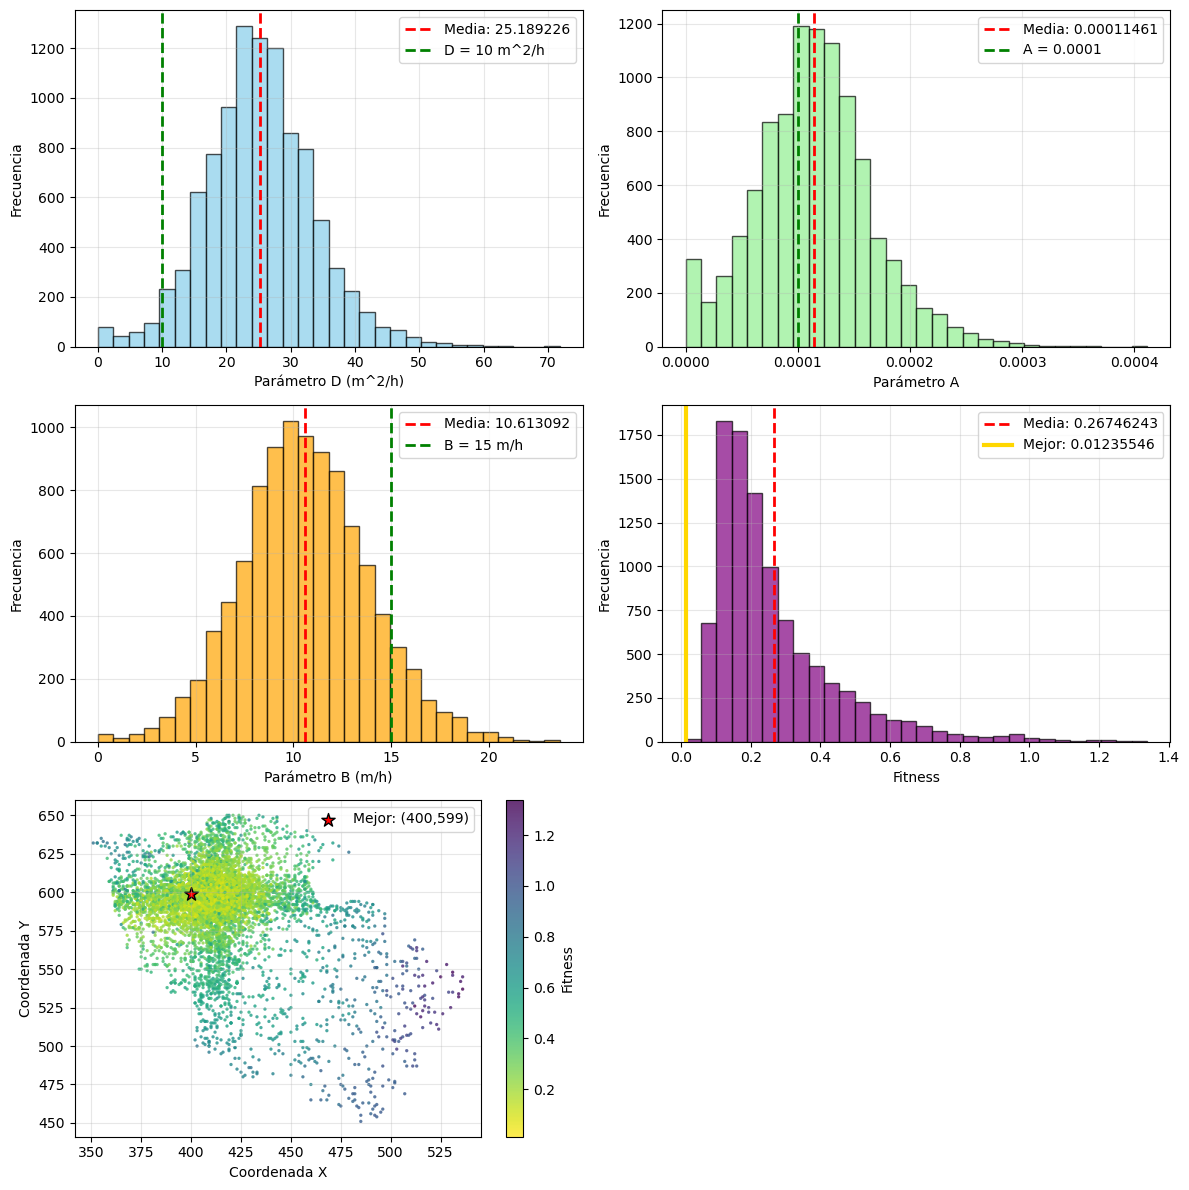

In [34]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN

# Detectar automáticamente la última generación
ultima_generacion = df_exp1['generacion'].max()
gen_ultima = df_exp1[df_exp1['generacion'] == ultima_generacion].copy()

# Crear figura con 3 filas y 2 columnas (6 ejes en total, usamos 5)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # pasar a lista simple para indexar fácilmente

n_bins = 30

# 1. Distribución del parámetro D
axes[0].hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
axes[0].axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
# axes[0].axvline(gen_ultima['D'].mean()-gen_ultima['D'].std(), color='blue', linestyle='--', linewidth=2)
# axes[0].axvline(gen_ultima['D'].mean()+gen_ultima['D'].std(), color='blue', linestyle='--', linewidth=2,
                #   label=f'Desviacion Estándar: {gen_ultima["D"].std():.6f}')
axes[0].set_xlabel('Parámetro D (m^2/h)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Distribución del parámetro A
axes[1].hist(gen_ultima['A'], bins=n_bins, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
axes[1].axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
axes[1].set_xlabel('Parámetro A')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribución del parámetro B
axes[2].hist(gen_ultima['B'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[2].axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
axes[2].axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
axes[2].set_xlabel('Parámetro B (m/h)')
axes[2].set_ylabel('Frecuencia')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. Distribución del fitness
axes[3].hist(gen_ultima['fitness'], bins=n_bins, color='purple', alpha=0.7, edgecolor='black')
axes[3].axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
axes[3].axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=3,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
axes[3].set_xlabel('Fitness')
axes[3].set_ylabel('Frecuencia')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# 5. Puntos de ignición coloreados por fitness
scatter = axes[4].scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
axes[4].scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=100, marker='*', edgecolors='black', linewidth=1,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
axes[4].set_xlabel('Coordenada X')
axes[4].set_ylabel('Coordenada Y')
axes[4].legend()
axes[4].grid(True, alpha=0.3)
fig.colorbar(scatter, ax=axes[4], label='Fitness')

# Eliminar el subplot vacío (el sexto)
fig.delaxes(axes[5])

# Ajustar diseño
plt.tight_layout()
plt.savefig(f'resultados_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experimento 2

Ajustamos los parámetros $D$, $A$, $B$, $\beta$, $\gamma$ y las coordenadas del punto de ignición $(x,y)$. El terreno es homogéneo así que hay un solo tipo de combustible

In [43]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp2.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "x", "y",
        "beta", "gamma"
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   x = {row['x']}")
    print(f"   y = {row['y']}")
    print(f"   beta = {row['beta']}")
    print(f"   gamma = {row['gamma']}")
    print(f"   Fitness = {row['fitness']}")


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#217857
   Generación: 21
   D = 22.733966827392575
   A = 0.000134453875944
   B = 15.831461906433104
   x = 399.0
   y = 604.0
   beta = 1.0283598
   gamma = 0.27797645
   Fitness = 0.0099804417855499

#200784
   Generación: 20
   D = 37.001277923583984
   A = 0.0001507987617515
   B = 17.496341705322266
   x = 398.0
   y = 605.0
   beta = 1.5000511
   gamma = 0.8882019
   Fitness = 0.0142084675563736

#199919
   Generación: 19
   D = 37.001277923583984
   A = 0.0001507987617515
   B = 17.496341705322266
   x = 398.0
   y = 605.0
   beta = 1.5000511
   gamma = 0.8882019
   Fitness = 0.0142084675563736

#172480
   Generación: 17
   D = 18.83234596252441
   A = 0.0001221757556777
   B = 14.761786460876465
   x = 400.0
   y = 605.0
   beta = 1.2719219
   gamma = 0.45786506
   Fitness = 0.0158479061205706

#195202
   Generación: 19
   D = 18.83234596252441
   A = 0.0001221757556777
   B = 14.761786460876465
   x = 400.0
   y = 605.0
   beta = [1.2719219

### Análisis de la última Generación

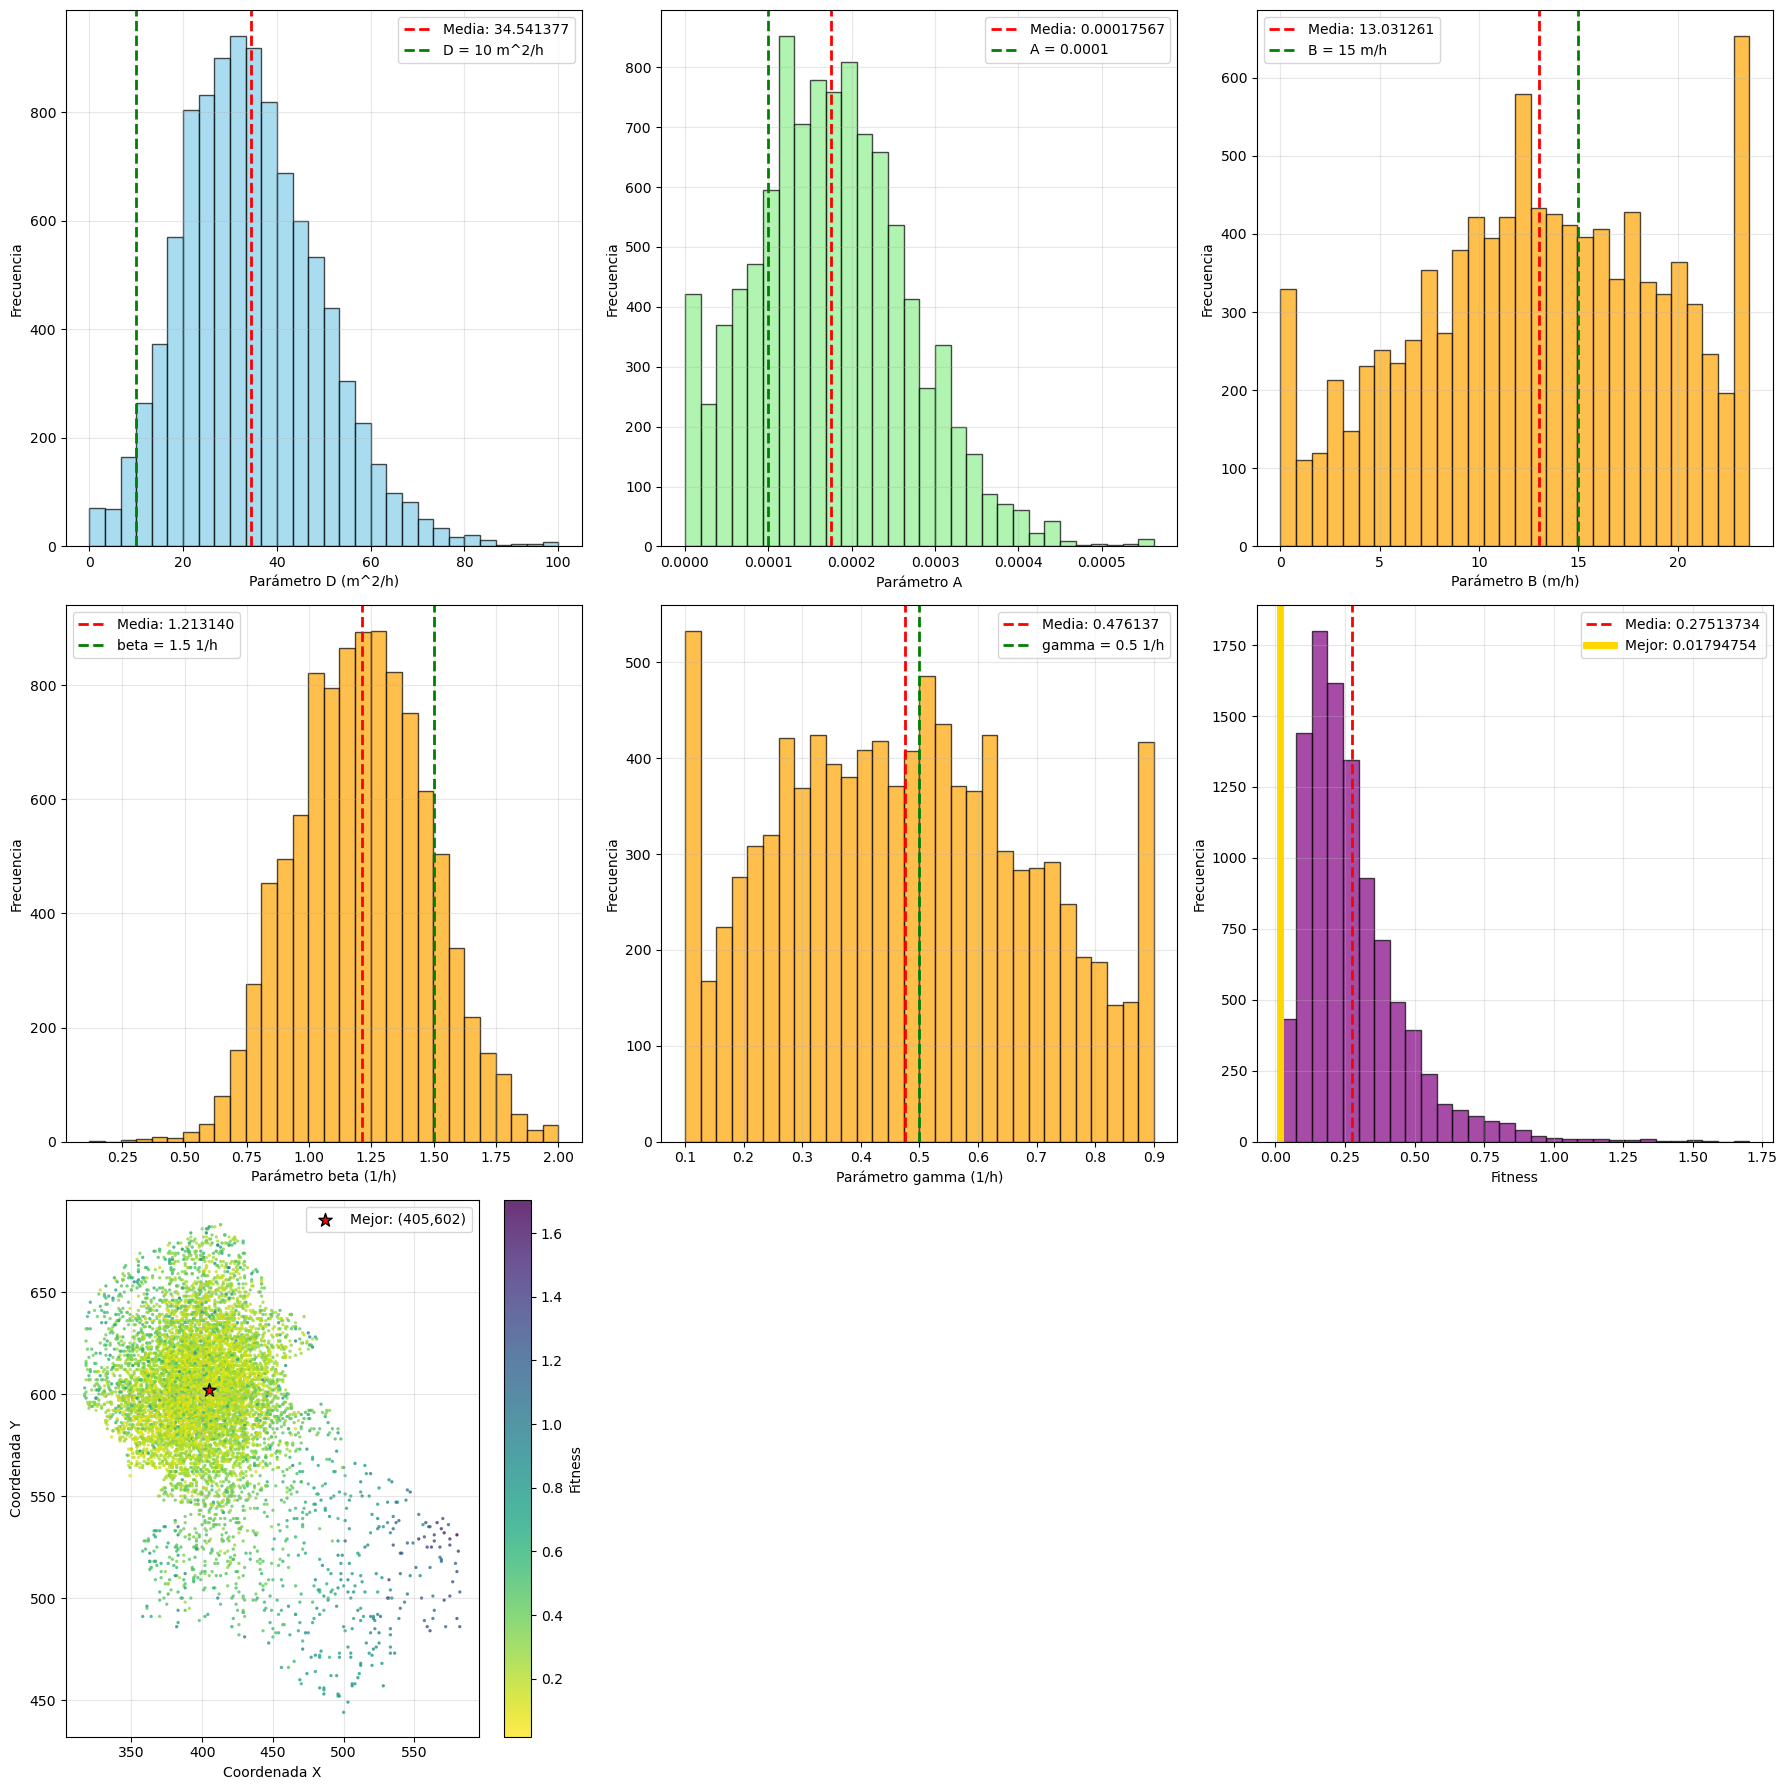

In [46]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN

# Detectar automáticamente la última generación
ultima_generacion = df_exp2['generacion'].max()
gen_ultima = df_exp2[df_exp2['generacion'] == ultima_generacion].copy()

# Crear figura con 3 filas y 3 columnas (6 ejes en total, usamos 5)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()  # pasar a lista simple para indexar fácilmente

n_bins = 30

# 1. Distribución del parámetro D
axes[0].hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
axes[0].axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
axes[0].set_xlabel('Parámetro D (m^2/h)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Distribución del parámetro A
axes[1].hist(gen_ultima['A'], bins=n_bins, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
axes[1].axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
axes[1].set_xlabel('Parámetro A')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribución del parámetro B
axes[2].hist(gen_ultima['B'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[2].axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
axes[2].axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
axes[2].set_xlabel('Parámetro B (m/h)')
axes[2].set_ylabel('Frecuencia')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].hist(gen_ultima['beta'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[3].axvline(gen_ultima['beta'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta"].mean():.6f}')
axes[3].axvline(1.5, color='green', linestyle='--', linewidth=2,
                 label=f'beta = {1.5} 1/h')
axes[3].set_xlabel('Parámetro beta (1/h)')
axes[3].set_ylabel('Frecuencia')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

axes[4].hist(gen_ultima['gamma'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[4].axvline(gen_ultima['gamma'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma"].mean():.6f}')
axes[4].axvline(0.5, color='green', linestyle='--', linewidth=2,
                 label=f'gamma = {0.5} 1/h')
axes[4].set_xlabel('Parámetro gamma (1/h)')
axes[4].set_ylabel('Frecuencia')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

# 4. Distribución del fitness
axes[5].hist(gen_ultima['fitness'], bins=n_bins, color='purple', alpha=0.7, edgecolor='black')
axes[5].axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
axes[5].axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=5,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
axes[5].set_xlabel('Fitness')
axes[5].set_ylabel('Frecuencia')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

# 5. Puntos de ignición coloreados por fitness
scatter = axes[6].scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
axes[6].scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=100, marker='*', edgecolors='black', linewidth=1,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
axes[6].set_xlabel('Coordenada X')
axes[6].set_ylabel('Coordenada Y')
axes[6].legend()
axes[6].grid(True, alpha=0.3)
fig.colorbar(scatter, ax=axes[6], label='Fitness')

# Eliminar el subplot vacío (el sexto)
fig.delaxes(axes[7])
fig.delaxes(axes[8])

# Ajustar diseño
plt.tight_layout()
plt.savefig(f'resultados_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
plt.style.use(['science', 'ieee'])  # estilo global para todos los gráficos

n_bins = 30
ultima_generacion = df_exp2['generacion'].max()
gen_ultima = df_exp2[df_exp2['generacion'] == ultima_generacion].copy()

# 1. Distribución del parámetro D
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(figsize=(3.5, 3.0))  # tamaño típico de paper (en pulgadas)
    ax.hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
    ax.axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=1.2,
                  label=f'Mean: {gen_ultima["D"].mean():.6f}')
    ax.axvline(10, color='green', linestyle='--', linewidth=1.2,
                  label=f'D = {10} m$^2$/h')
    ax.set_xlabel(r'Parameter $D$ (m$^2$/h)')
    ax.set_ylabel('Frequence')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'distribucion_D_generacion_{ultima_generacion}.pdf', dpi=600, bbox_inches='tight')
    plt.close()

## Experimento 3

En este experimento generamos un multiincendio en 3 focos distintos y ajustamos los parámetros $D$, $A$, $B$, $\beta_i$, $\gamma_i$ para $i \in \{1, 2, 3, 4, 5\}$

In [9]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp3.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "beta_1", "beta_2", "beta_3", "beta_4", "beta_5",
        "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5",
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
# print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
# for i, row in top10.iterrows():
#     print(f"\n#{i+1}")
#     print(f"   Generación: {row['generacion']}")
#     print(f"   D = {row['D']}")
#     print(f"   A = {row['A']}")
#     print(f"   B = {row['B']}")
#     print(f"   beta_1 = {row['beta_1']}")
#     print(f"   beta_2 = {row['beta_2']}")
#     print(f"   beta_3 = {row['beta_3']}")
#     print(f"   beta_4 = {row['beta_4']}")
#     print(f"   beta_5 = {row['beta_5']}")
#     print(f"   gamma_1 = {row['gamma_1']}")
#     print(f"   gamma_2 = {row['gamma_2']}")
#     print(f"   gamma_3 = {row['gamma_3']}")
#     print(f"   gamma_4 = {row['gamma_4']}")
#     print(f"   gamma_5 = {row['gamma_5']}")
#     print(f"   Fitness = {row['fitness']}")

mejor_individuo = top10
print(mejor_individuo)

                D         A          B    beta_1    beta_2    beta_3  \
326397  14.235160  0.000109  14.139585  0.552312  0.470305  0.980062   
254605  14.842948  0.000102  15.815122  0.546020  0.702951  1.019585   
309702   9.613118  0.000111  16.212740  0.819683  0.711298  0.678834   
324211  12.000384  0.000108  14.441323  0.516808  0.603783  0.667463   
189045  16.637909  0.000103  15.669956  0.590765  0.535635  1.154910   
328326  10.039337  0.000104  16.974218  0.489802  0.410774  1.045355   
300629   5.243141  0.000091  12.081995  0.837995  0.649286  1.031514   
182047   8.736176  0.000104  17.891991  0.480764  0.530729  1.121235   
321573  14.983048  0.000092  13.191006  0.450707  0.587695  1.206862   
267532  22.341478  0.000108  13.501202  0.546020  0.548155  0.636074   

          beta_4    beta_5   gamma_1   gamma_2   gamma_3   gamma_4   gamma_5  \
326397  1.574480  0.969892  0.234935  0.189832  0.360306  0.270614  0.361892   
254605  1.739100  0.481623  0.222718  0.382947 

## Análisis de la última generación
### Análisis específico de los mejores resultados obtenidos

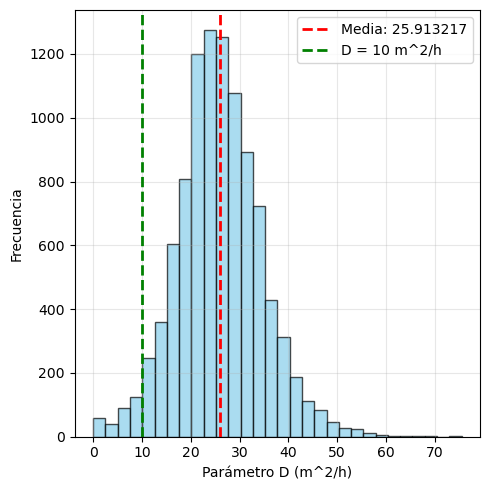

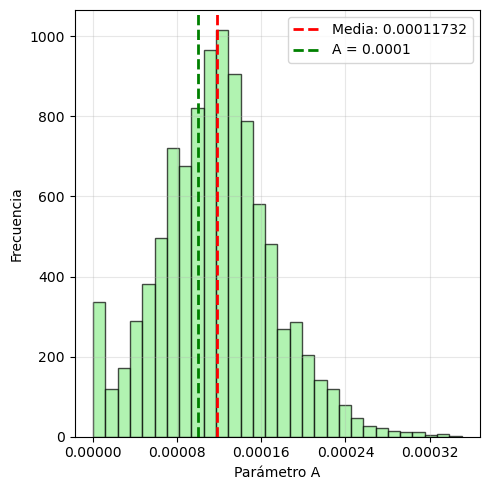

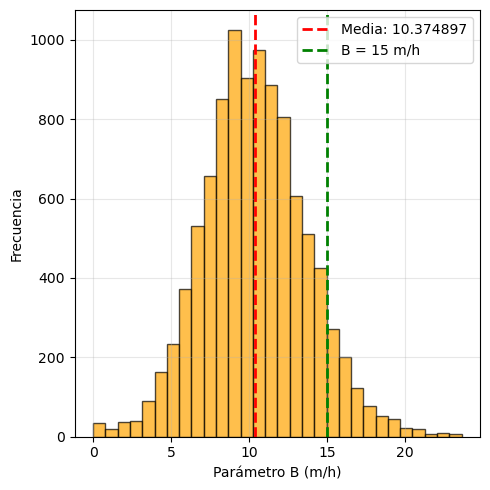

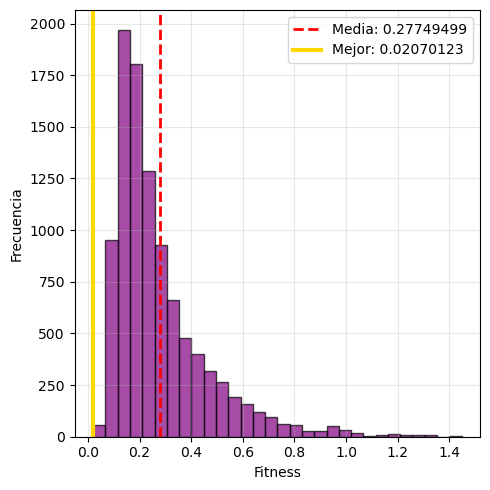

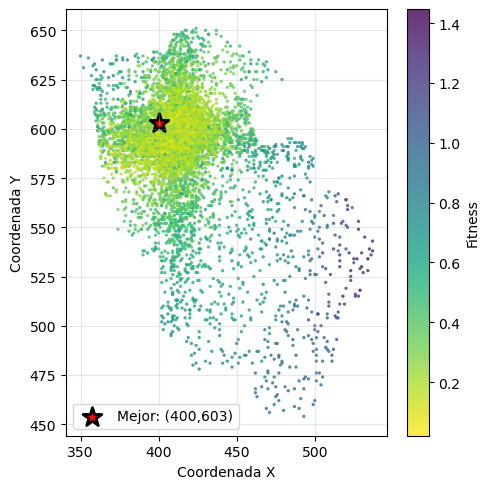

In [7]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN

# Detectar automáticamente la última generación
ultima_generacion = df_total['generacion'].max()
gen_ultima = df_total[df_total['generacion'] == ultima_generacion].copy()

n_bins = 30

# Seleccionar los mejores 1000 individuos de la última generación (fitness más pequeño)
# gen_ultima = gen_ultima.nsmallest(100, 'fitness')

# 1. Distribución del parámetro D en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
plt.axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
ax.set_xlabel('Parámetro D (m^2/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_D_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 2. Distribución del parámetro A en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['A'], bins=n_bins, color='lightgreen', alpha=0.7, edgecolor='black')
ticks = np.linspace(gen_ultima['A'].min(), gen_ultima['A'].max(), 6)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
plt.axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
ax.set_xlabel('Parámetro A')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_A_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 3. Distribución del parámetro B en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['B'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
plt.axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
ax.set_xlabel('Parámetro B (m/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_B_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['beta_1'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['beta_1'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["beta_1"].mean():.6f}')
# plt.axvline(0.91, color='green', linestyle='--', linewidth=2,
#                  label=f'β1 = {0.91}')
# ax.set_xlabel('Parámetro β1')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_beta_1_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['beta_2'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['beta_2'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["beta_2"].mean():.6f}')
# plt.axvline(0.72, color='green', linestyle='--', linewidth=2,
#                  label=f'β2 = {0.72}')
# ax.set_xlabel('Parámetro β2')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_beta_2_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['beta_3'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['beta_3'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["beta_3"].mean():.6f}')
# plt.axvline(1.38, color='green', linestyle='--', linewidth=2,
#                  label=f'β3 = {1.38}')
# ax.set_xlabel('Parámetro β3')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_beta_3_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['beta_4'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['beta_4'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["beta_4"].mean():.6f}')
# plt.axvline(1.94, color='green', linestyle='--', linewidth=2,
#                  label=f'β4 = {1.94}')
# ax.set_xlabel('Parámetro β4')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_beta_4_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['beta_5'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['beta_5'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["beta_5"].mean():.6f}')
# plt.axvline(0.75, color='green', linestyle='--', linewidth=2,
#                  label=f'β5 = {0.75}')
# ax.set_xlabel('Parámetro β5')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_beta_5_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['gamma_1'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['gamma_1'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["gamma_1"].mean():.6f}')
# plt.axvline(0.5, color='green', linestyle='--', linewidth=2,
#                  label=f'γ1 = {0.5}')
# ax.set_xlabel('Parámetro γ1')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_gamma_1_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['gamma_2'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['gamma_2'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["gamma_2"].mean():.6f}')
# plt.axvline(0.38, color='green', linestyle='--', linewidth=2,
#                  label=f'γ2 = {0.38}')
# ax.set_xlabel('Parámetro γ2')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_gamma_2_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['gamma_3'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['gamma_3'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["gamma_3"].mean():.6f}')
# plt.axvline(0.84, color='green', linestyle='--', linewidth=2,
#                  label=f'γ3 = {0.84}')
# ax.set_xlabel('Parámetro γ3')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_gamma_3_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['gamma_4'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['gamma_4'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["gamma_4"].mean():.6f}')
# plt.axvline(0.45, color='green', linestyle='--', linewidth=2,
#                  label=f'γ4 = {0.45}')
# ax.set_xlabel('Parámetro γ4')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_gamma_4_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(5,5))
# plt.hist(gen_ultima['gamma_5'], bins=n_bins, color='lightcoral', alpha=0.7, edgecolor='black')
# plt.axvline(gen_ultima['gamma_5'].mean(), color='red', linestyle='--', linewidth=2,
#                 label=f'Media: {gen_ultima["gamma_5"].mean():.6f}')
# plt.axvline(0.14, color='green', linestyle='--', linewidth=2,
#                  label=f'γ5 = {0.14}')
# ax.set_xlabel('Parámetro γ5')
# ax.set_ylabel('Frecuencia')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'distribucion_gamma_5_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 4. Distribución del fitness en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['fitness'], bins=n_bins, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
plt.axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=3,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
ax.set_xlabel('Fitness')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_fitness_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 5. Puntos de ignición coloreados por fitness (última generación)
fig, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
# Destacar el mejor individuo
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
plt.scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=200, marker='*', edgecolors='black', linewidth=2,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Fitness')
plt.tight_layout()
plt.savefig(f'distribucion_puntos_ignicion_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')